In [1]:
# Starting with the same data considered in earlier lectures, here we will attempt to
# reconstruct the state of the system from limited measurements
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
import gdown


In [2]:
# download data file from Google Drive


data_url =   'https://drive.google.com/file/d/1ep8Xo3TERWFINYQ_OzueaQFGCjyF2jmg/view?usp=sharing'
output = 'AirfoilData.npz'
gdown.download(data_url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1ep8Xo3TERWFINYQ_OzueaQFGCjyF2jmg
To: C:\Users\ehven\Documents\Sai\AirfoilData.npz
100%|██████████| 20.0M/20.0M [00:01<00:00, 10.6MB/s]


'AirfoilData.npz'

In [3]:
data = np.load('AirfoilData.npz',allow_pickle=False)
Data = data['DataMat'] # Vorticity data (2d array)
X = data['X']
Y = data['Y']
time =  data['time']
Lift =  data['Lift']
Drag =  data['Drag']

(-0.66, 17.3, -2.06, 1.9)

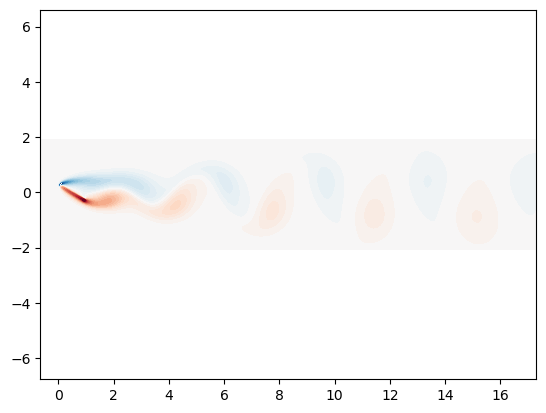

In [4]:
# Pick an instance in time, and visualize
# (first rearrange vector to a 2d array)
timeindex = 0;
ny, nx = X.shape
DataReshape = np.reshape(Data[:,timeindex],(ny,nx))


clevels = np.linspace(-10,10,50)
plt.contourf(X,Y,DataReshape,clevels,cmap="RdBu_r")
plt.axis('equal')

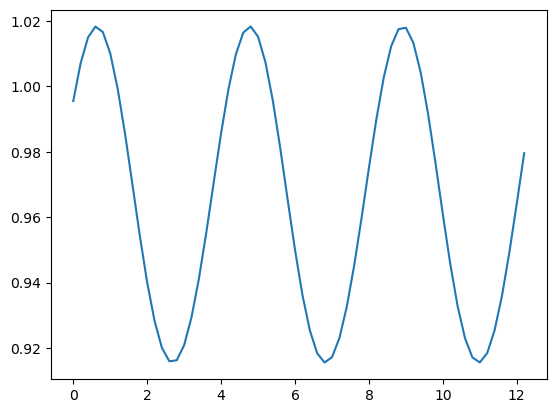

In [5]:
plt.plot(time,Lift)

In [6]:
# First subtract the mean for both input (Vorticity) and output (Lift) data

LiftSub = Lift - np.mean(Lift)
nspace, ntime = Data.shape
DataMean = np.mean(Data,axis=1)
DataSub= Data - np.tile(DataMean[:,np.newaxis],(1,ntime))

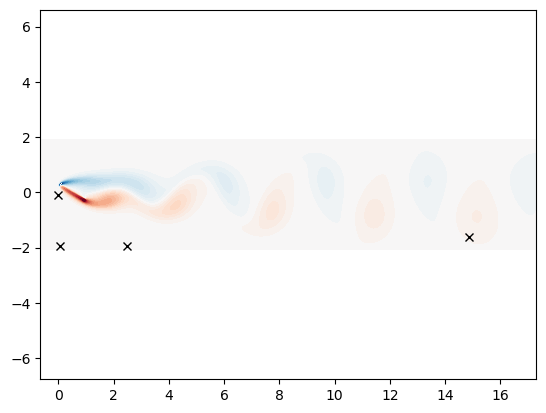

In [7]:
# select random measurements
nRandom = 4;
rng = np.random.default_rng()
randomSamples = rng.choice(nspace, size = nRandom, replace = False)
plt.contourf(X,Y,DataReshape,clevels,cmap="RdBu_r")
plt.axis('equal')
Xvec = np.reshape(X,nspace)
Yvec = np.reshape(Y,nspace)

plt.plot(Xvec[randomSamples],Yvec[randomSamples],'kx')

(-0.66, 17.3, -2.06, 1.9)

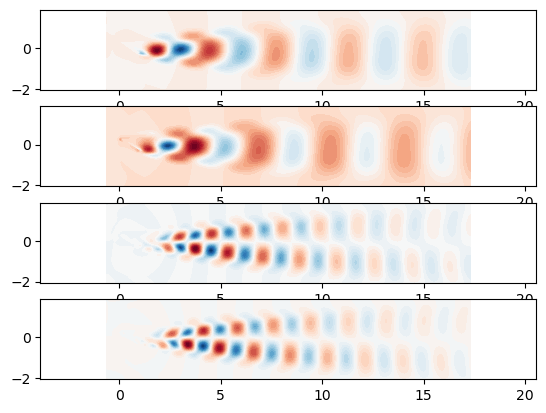

In [8]:
r = 4
U,Sigma,VT = la.svd(DataSub,full_matrices=0)
# truncate SVD to the same dimension as the autoencoder
Ur = U[:,:r]
Sigmar = np.diag(Sigma[:r])
VTr = VT[:r,:]
SVDmode1 = np.reshape(U[:,0],(ny,nx))
SVDmode2 = np.reshape(U[:,1],(ny,nx))
SVDmode3 = np.reshape(U[:,2],(ny,nx))
SVDmode4 = np.reshape(U[:,3],(ny,nx))
figs, axs = plt.subplots(4,1)
nlevels = 50
axs[0].contourf(X,Y,SVDmode1,nlevels,cmap="RdBu_r")
axs[0].axis('equal')
axs[1].contourf(X,Y,SVDmode2,nlevels,cmap="RdBu_r")
axs[1].axis('equal')
axs[2].contourf(X,Y,SVDmode3,nlevels,cmap="RdBu_r")
axs[2].axis('equal')
axs[3].contourf(X,Y,SVDmode4,nlevels,cmap="RdBu_r")
axs[3].axis('equal')

In [9]:
# Sample at a small number of locations

timeIndex = 20

RandomMeasurements = DataSub[randomSamples,timeIndex]

# Solve Ur*x = RandomMeasurements
# analogous to Theta*s = y
c = la.pinv(Ur[randomSamples,:])@RandomMeasurements
print(c)

[ 57.25595266 -19.25671567  30.86365427 -11.71909543]


(-0.66, 17.3, -2.06, 1.9)

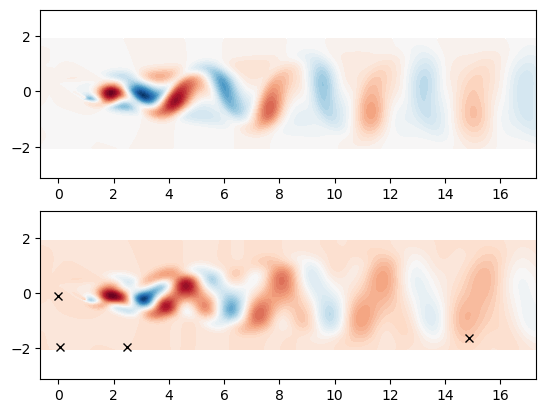

In [10]:
# reconstruct full state
DataSubEstimated = Ur@c
DataSubEstimatedReshape = np.reshape(DataSubEstimated,(ny,nx))

DataSubTrueReshape = np.reshape(DataSub[:,timeIndex],(ny,nx))

figs, axs = plt.subplots(2,1)
nlevels = 50
axs[0].contourf(X,Y,DataSubTrueReshape,nlevels,cmap="RdBu_r")
axs[0].axis('equal')
plt.plot(Xvec[randomSamples],Yvec[randomSamples],'kx')
axs[1].contourf(X,Y,DataSubEstimatedReshape,nlevels,cmap="RdBu_r")
axs[1].axis('equal')




In [11]:
# if we want the best reconstruction, where should we measure?

# we will use a method based on a pivoted QR factorization of the singular vectors Ur

from scipy.linalg import qr

Q,R,P = qr(np.transpose(Ur),pivoting=True)

optimalSampleLocations = P[:r]
print(optimalSampleLocations)

# Do reconstruction with these measurements
OptimalMeasurements = DataSub[optimalSampleLocations,timeIndex]
cOpt = la.pinv(Ur[optimalSampleLocations,:])@OptimalMeasurements
print(cOpt)

[19902 19463 23938 25303]
[ 62.53428025  -8.40762188  -3.25231884 -18.80993915]


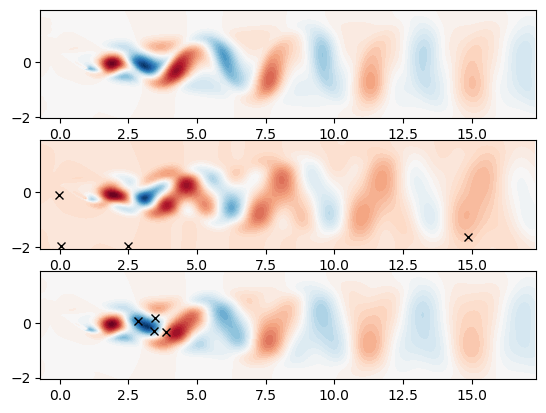

In [12]:
# Reconstruct full state from optimal measurements`
DataSubEstimatedOpt = Ur@cOpt
DataSubEstimatedOptReshape = np.reshape(DataSubEstimatedOpt,(ny,nx))

DataSubTrueReshape = np.reshape(DataSub[:,timeIndex],(ny,nx))

figs, axs = plt.subplots(3,1)
nlevels = 50
axs[0].contourf(X,Y,DataSubTrueReshape,nlevels,cmap="RdBu_r")
axs[0].axis('equal')

axs[1].contourf(X,Y,DataSubEstimatedReshape,nlevels,cmap="RdBu_r")
axs[1].axis('equal')
axs[1].plot(Xvec[randomSamples],Yvec[randomSamples],'kx')

axs[2].contourf(X,Y,DataSubEstimatedOptReshape,nlevels,cmap="RdBu_r")
axs[2].axis('equal')
axs[2].plot(Xvec[optimalSampleLocations],Yvec[optimalSampleLocations],'kx')


In [13]:
print(c)
print(cOpt)
cTrue = Sigmar@VTr[:,timeIndex]
print(cTrue)

[ 57.25595266 -19.25671567  30.86365427 -11.71909543]
[ 62.53428025  -8.40762188  -3.25231884 -18.80993915]
[ 61.93752057 -11.69133124  -0.48190482 -19.87311194]


In [14]:
# compare error
print(la.norm(cTrue-c))
print(la.norm(cTrue-cOpt))

33.5884530693242
4.4659152967797535


In [15]:
# What if the measurements are noisy?
noiseLevel = 0.1

OptimalMeasurementsNoisy = OptimalMeasurements + noiseLevel*np.random.normal(size=OptimalMeasurements.shape)

RandomMeasurementsNoisy = RandomMeasurements + noiseLevel*np.random.normal(size=RandomMeasurements.shape)

cOptNoisy = la.pinv(Ur[optimalSampleLocations,:])@OptimalMeasurementsNoisy
cRandNoisy = la.pinv(Ur[randomSamples,:])@RandomMeasurementsNoisy

print(cRandNoisy)
print(cOptNoisy)
print(cTrue)

[-4.41818879e+13 -7.40309144e+13  3.43408358e+14  7.67844938e+13]
[ 61.51171951  -8.91773209  -6.410854   -22.01168103]
[ 61.93752057 -11.69133124  -0.48190482 -19.87311194]
